# Projected Density of States
This notebook will demonstrate use of the PDoS module for computing the Projected Density of States. We will show how it is used in both the cubic and linear scaling mode. After that, we'll do some extra activities related to fragments. Finally, we will cover some current limitations of the O(N) mode.

In [1]:
geom = """HETATM    1  O   HOH     1      -0.702  -0.056   0.010  1.00  0.00           O  
HETATM    2  H   HOH     1      -1.022   0.847  -0.011  1.00  0.00           H  
HETATM    3  H   HOH     1       0.258   0.042   0.005  1.00  0.00           H  
HETATM    4  O   HOH     2       2.221   0.027   0.001  1.00  0.00           O  
HETATM    5  H   HOH     2       2.597  -0.412   0.767  1.00  0.00           H  
HETATM    6  H   HOH     2       2.593  -0.449  -0.745  1.00  0.00           H  """

In [2]:
from io import StringIO
from BigDFT.IO import read_pdb
with StringIO(geom) as ifile:
    sys = read_pdb(ifile)

In [3]:
from BigDFT.Calculators import SystemCalculator
code = SystemCalculator(skip=True, verbose=False)

## Cubic Scaling Mode
First, we will show how to plot the PDoS in the cubic scaling mode.

In [4]:
from BigDFT.Inputfiles import Inputfile
inp = Inputfile()
inp.set_hgrid(0.4)
inp.set_xc("PBE")

We need to activate the PDoS feature. We will also add some extra empty orbitals for later comparison with the linear mode, which automatically has some empty states.

In [5]:
inp.calculate_pdos()
inp.add_empty_scf_orbitals(4)

In [6]:
log = code.run(sys=sys, input=inp, name="pdos-C")

Once the calculation has been completed, we access which projections are available.

In [7]:
from BigDFT.PDoS import cubic_projection_info
proj_list = cubic_projection_info(log)
print(proj_list)

{'O': {'s': [0, 6], 'px': [1, 7], 'py': [2, 8], 'pz': [3, 9]}, 'H': {'s': [4, 5, 10, 11]}}


Then using this information, we can process the `pdos.dat` file to get the weights.

In [8]:
from BigDFT.PDoS import cubic_projection_weights
weights = cubic_projection_weights(log, proj_list)

Then it is time to create a DoS object to help with the plotting.

In [9]:
from BigDFT.DoS import DoS
dos = DoS(energies=log.evals[0][0], units='AU', label="Total")

In [10]:
from numpy import array  # Needed since we're hopping over the k points
dos.append(energies=array(log.evals[0]), units='AU',
           norm=[[x['H']['s'] for x in weights]], label="Hs")
dos.append(energies=array(log.evals[0]), units='AU',
           norm=[[x['O']['s'] for x in weights]], label="Os")
dos.append(energies=array(log.evals[0]), units='AU',
           norm=[[x['O']['px'] + x['O']['py'] + x['O']['pz'] for x in weights]], label="Op")

Add the sum as a sanity check.

In [11]:
dos.append(energies=array(log.evals[0]), units='AU',
           norm=[[x['H']['s'] + 
                  x['O']['s'] + x['O']['px'] + x['O']['py'] + x['O']['pz'] 
                  for x in weights]], label="Sum")

Now we are ready to make a picture.

In [12]:
from bokeh.io import output_notebook
output_notebook(hide_banner=True) 
def label_fig(p):
    p.add_layout(p.legend[0], 'right')
    p.xaxis.axis_label = "Energy (eV)"
    p.legend.click_policy = "hide"
    p.toolbar_location = "right"
    p.aspect_ratio = 2
    return p

In [13]:
from bokeh.plotting import figure, show
from bokeh.palettes import Category10 

p = figure() 
for i, k in enumerate(dos.labels):
    color = Category10[10][i % 10]
    p.line(dos.get_curves()[k].x, dos.get_curves()[k].y, line_color=color, legend_label=k)

show(label_fig(p))

## Linear Scaling Mode
Now we can work on the linear scaling mode. First, the calculation has to be done. The `support_function_multiples` option is needed to help understand how well our support functions approximate s, p, etc. 

In [14]:
inp = Inputfile()
inp.set_hgrid(0.4)
inp.set_xc("PBE")
inp["import"] = "linear"
inp["lin_general"] = {"support_function_multipoles": True}

In [15]:
log = code.run(sys=sys, input=inp, name="pdos-L")

To post-process the linear scaling mode, we have to diagonalize the matrix to get the eigenvectors and eigenvalues. We also need the density matrix for projecting.

In [16]:
from BigDFT.PostProcessing import BigDFTool
tool = BigDFTool()
hmat = tool.get_matrix_h(log)
smat = tool.get_matrix_s(log)
kmat = tool.get_matrix_k(log)

In [17]:
from scipy.linalg import eigh
evals, evec = eigh(hmat.todense(), b=smat.todense())

Now we can apply a similar processing as to the cubic mode to get the weights. Importantly, you want to pass the density (times one half) and overlap matrix in if you are using the Mulliken representation. Otherwise, the eigenvectors should be recomputed after Lowdin orthogonalization is applied.

In [18]:
from BigDFT.PDoS import linear_projection_info, linear_projection_weights
proj_info = linear_projection_info(log)
weights = linear_projection_weights(evec, proj_info, s = smat, k = 0.5 * kmat)

Let's plot and see the results.

In [19]:
dosL = DoS(energies=evals, units='AU', label="Total")
dosL.append(energies=array([evals]), units='AU',
            norm=[[x['H']['s'] for x in weights]], label="Hs")
dosL.append(energies=array([evals]), units='AU',
            norm=[[x['O']['s'] for x in weights]], label="Os")
dosL.append(energies=array([evals]), units='AU',
            norm=[[x['O']['px'] + x['O']['py'] + x['O']['pz'] for x in weights]], label="Op")
dosL.append(energies=array([evals]), units='AU',
            norm=[[x['H']['s'] + 
                   x['O']['s'] + x['O']['px'] + x['O']['py'] + x['O']['pz'] 
                   for x in weights]], label="Sum")

In [20]:
p = figure() 
for i, k in enumerate(dosL.labels):
    color = Category10[10][i % 10]
    p.line(dosL.get_curves()[k].x, dosL.get_curves()[k].y, line_color=color, legend_label=k)
show(label_fig(p))

Notice how the density matrix has been used to filter out the virtual orbitals. They could be recovered by passing the overlap matrix as the density matrix.

We will also plot the linear and cubic values side by side to get a better idea of the differences.

In [21]:
p = figure() 
for i, k in enumerate(dosL.labels):
    color = Category10[10][i % 10]
    p.line(dosL.get_curves()[k].x, dosL.get_curves()[k].y, line_color=color)
    p.line(dos.get_curves()[k].x, -1*dos.get_curves()[k].y, line_color=color, legend_label=k)
p.yaxis.axis_label = "Cubic <-- DoS --> Linear"
show(label_fig(p))

The agreement is good, with the shift in the fermi energy explaning most of the difference. The virtual orbitals are also rather different, since virtual states are not optimized by default in the linear mode.

## Fragment Projected Density of States
It might be useful to plot only the density of states associated with certain fragments of a system. We can do this in the linear scaling mode using a similar approach. Let's inspect our previous `proj_info` variable.

In [22]:
print(proj_info)

{'H': {'s': [0, 5, 6, 11]}, 'O': {'s': [1, 7], 'px': [2, 8], 'py': [3, 9], 'pz': [4, 10]}}


We see that it is a two layered dictionary, which maps atom types to projection types to indices.

In [23]:
fidx = tool.get_frag_indices(sys, log)
print(fidx)

{'HOH:1': [1, 2, 3, 4, 0, 5], 'HOH:2': [7, 8, 9, 10, 11, 6]}


The fragment indices provide a similar structure, though not as deep. By adding a layer to indicate our intentions to fragment the system, we can get the weights on each fragment.

In [24]:
weights = linear_projection_weights(evec, {"frag": fidx}, s = smat, k = 0.5 * kmat)
print(weights[0])

{'frag': {'HOH:1': 0.00493624865071806, 'HOH:2': 0.9950637513633104}}


Note that you can also use `compute_fragment_weights`:

In [25]:
from BigDFT.PDoS import compute_fragment_weights
weights = compute_fragment_weights(sys, log, evec, evals, s = smat, k = 0.5 * kmat)
print(weights[0])

{'HOH:1': 0.00493624865071806, 'HOH:2': 0.9950637513633104}


In [26]:
dosF = DoS(energies=evals, units='AU', label="Total")
for fragid in sys:
    dosF.append(energies=array([evals]), units='AU',
                norm=[[x[fragid] for x in weights]], label=fragid)

In [27]:
p = figure(aspect_ratio=2, toolbar_location="right") 

for i, k in enumerate(dosF.labels):
    color = Category10[10][i % 10]
    if k != "HOH:1":
        p.line(dosF.get_curves()[k].x, dosF.get_curves()[k].y, line_color=color, legend_label=k)
    if k != "HOH:2":
        p.line(dosF.get_curves()[k].x, -1 *dosF.get_curves()[k].y, line_color=color, legend_label=k)

show(label_fig(p))

This approach let's us assign particular peaks to a given fragment, which can help with interpretation.

## Block - Diagonal Approximation
Having to diagonalize the full matrix is a downside of the linear scaling mode. Of course, this only has to be done once at the end of the calculation, and BigDFT's in-situ optimized, minimal basis keeps the matrix small. You can also easily use our remotemanager library to do the diagonalization on the remote machine. Nonetheless, sometimes you want to do something cheaper.

As a first order approximation of the divide and conquer algorithm we proposed in a [recent paper](https://pubs.aip.org/aip/jcp/article/158/16/164114/2886899), we can assume to that the Hamiltonian is fragment block diagonal. The purity indicator shows that this is a reasonable approximation. 

In [28]:
tool.run_compute_purity(sys, log)

{'HOH:1': -0.0035964047509253333, 'HOH:2': -0.0035964046973216146}

Extract the submatrices and diagonalize. 

In [29]:
target = list(sys)[0]
sub_s = smat[:, fidx[target]]
sub_s = sub_s[fidx[target], :]
sub_h = hmat[:, fidx[target]]
sub_h = sub_h[fidx[target], :]
sub_k = kmat[:, fidx[target]]
sub_k = sub_k[fidx[target], :]
print(smat.shape, sub_s.shape)
sub_eval, sub_evec = eigh(sub_h.todense(), b=sub_s.todense())

(12, 12) (6, 6)


The matrix size has been cut in half in this case. How accurate is the result?

In [30]:
proj_info_sub = {}
for k, v in proj_info.items():
    proj_info_sub[k] = {}
    for p, indices in v.items():
        if p not in proj_info_sub[k]:
            proj_info_sub[k][p] = []
        for i in indices:
            if i in fidx[target]:
                proj_info_sub[k][p].append(i)

In [31]:
weights_sub = linear_projection_weights(sub_evec, proj_info_sub, s = sub_s, k = 0.5 * sub_k)

In [32]:
dosS = DoS(energies=sub_eval, units='AU', label="Full")
dosS.append(energies=array([sub_eval]), units='AU',
            norm=[[x['H']['s'] + x['O']['s'] + x['O']['px'] + x['O']['py'] + x['O']['pz'] for x in weights_sub]], label=target)

In [33]:
p = figure() 
p.line(dosF.get_curves()[target].x, dosF.get_curves()[target].y, line_color="black", legend_label="Full")
p.line(dosS.get_curves()[target].x, -1*dosS.get_curves()[target].y, line_color="red", legend_label="Sub Matrix")
show(label_fig(p))

We get the main peaks from this simple approach. However, we see that there is smallers features that are missing, which we can interpret as the orbitals of the environment fragment overlapping with the target. This feature could be recovered by using a buffer and project approach, as detailed in the paper.

## Cautions about the O(N) Mode
There are some potential pitfalls to the O(N) mode right now. Let's consider a different system.

In [34]:
from BigDFT.Database.Molecules import get_molecule
sys = get_molecule("CO2")

In [35]:
inp.write_support_functions_on_disk(format='21')  # Will come in handy later
log = code.run(sys=sys, input=inp, name="pdos-P")

When we try to get information about the projection, something will go wrong.

In [36]:
proj_info = linear_projection_info(log)
print(proj_info)

{'C': {'dz^2': [0], 'px': [1], 'py': [2], 'pz': [3]}, 'O': {'s': [4, 8], 'px': [5, 9], 'py': [6, 10], 'pz': [7, 11]}}


As you can see, there is a challenge to determining how to describe the first support function of carbon. Instead of the expected s, it is identified as d_z^2. This comes from analysis of the multipoles.

In [37]:
print(log.log["Gross support functions moments"]["Multipole coefficients"]["values"][0])

{'sym': 'C-1', 'Atom number': 1, 'r': [0.0018973985789227112, 0.0018973983493686356, 0.003224343965963172], 'multipole character': 'gross', 'Delta r': [0.001897399, 0.001897398, 0.003224344], 'q0': [0.6636242], 'q1': [-0.003883519, -0.01183993, -0.003883532], 'q2': [0.001666321, -0.003194405, -1.0, -0.003194408, -6.179192e-09], 'scaling factor': 0.867, 'type': 'unknown'}


Since we wrote the support functions to file, maybe we should visualize this one. It is available in the data directory as a cube file.

In [38]:
from os import system

# Write the shifted xyz coordinates for pymol
with open("for_pymol.xyz", "w") as ofile:
    pos = log.log["Atomic structure"]["positions"]
    ofile.write(str(len(pos)) + "\n\n")
    for at in pos:
        sym = list(at)[0]
        ofile.write(sym + " " + " ".join([str(x) for x in at[sym]]) + "\n")

# Pymol input file
with open("for_pymol.pml", "w") as ofile:
    ofile.write("load for_pymol.xyz\n")
    ofile.write("show licorice\n")
    ofile.write("load data-pdos-P/SupFun-k001-NR.b000001.cube\n")
    ofile.write("isomesh mesh-p, SupFun-k001-NR.b000001, 0.001\n")
    ofile.write("color blue, mesh-p\n")
    ofile.write("isomesh mesh-n, SupFun-k001-NR.b000001, -0.001\n")
    ofile.write("color red, mesh-n\n")
    view = """set_view (\
    -0.036075424,    0.998735070,    0.035015449,\
    -0.508902729,    0.011795374,   -0.860742271,\
    -0.860068142,   -0.048871227,    0.507835031,\
     0.000000000,    0.000000000,  -11.975823402,\
     4.074664593,    4.074664593,    4.286335468,\
     3.589735985,   20.361915588,  -20.000000000 )\n"""
    ofile.write(view)
    ofile.write("png orbital.png, ray = 1\n")
    ofile.write("quit\n")
system("pymol -cqi for_pymol.pml >/dev/null")

0

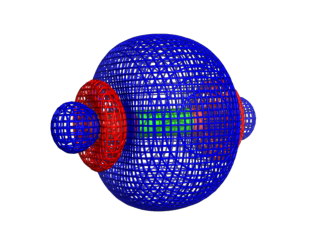

In [40]:
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
fig, axs = plt.subplots(figsize=(4, 3))
image = mpimg.imread("orbital.png")
axs.imshow(image)
_ = axs.axis('off')

Depending on your use case, you might want to manually manipulate such a label, or you can change the cutoff.

In [41]:
proj_info = linear_projection_info(log, thresh=0.5)
print(proj_info)

{'C': {'s': [0], 'px': [1], 'py': [2], 'pz': [3]}, 'O': {'s': [4, 8], 'px': [5, 9], 'py': [6, 10], 'pz': [7, 11]}}


Let's go ahead and plot it.

In [42]:
hmat = tool.get_matrix_h(log)
smat = tool.get_matrix_s(log)
kmat = tool.get_matrix_k(log)
evals, evec = eigh(hmat.todense(), b=smat.todense())
weights = linear_projection_weights(evec, proj_info, s = smat, k = 0.5 * kmat)

In [43]:
dosL = DoS(energies=evals, units='AU', label="Total")
dosL.append(energies=array([evals]), units='AU',
            norm=[[x['C']['s'] for x in weights]], label="Cs (or dz^2)")

In [44]:
p = figure() 
for i, k in enumerate(dosL.labels):
    color = Category10[10][i % 10]
    p.line(dosL.get_curves()[k].x, dosL.get_curves()[k].y, line_color=color,  legend_label=k)
show(label_fig(p))

## Caution about Spin Polarization
It is possible to compute the PDoS with spin polarization in the cubic scaling mode, one just needs to make a small modification to how the weights are used.

In [45]:
inp = Inputfile()
inp.set_hgrid(0.4)
inp.set_xc("PBE")
inp.spin_polarize()
inp.calculate_pdos()
inp["import"] = "mixing"  # for robustness

In [46]:
log = code.run(sys=sys, input=inp, name="pdos-C_spin")

Mainly, you need to split the weights into up and down.

In [47]:
proj_list = cubic_projection_info(log)
weights = cubic_projection_weights(log, proj_list)
weights_up = weights[:int(len(weights) / 2)]
weights_down = weights[int(len(weights) / 2):]

Then plotting can go as usual.

In [48]:
dos_up = DoS(energies=log.evals[0][0], units='AU', label="Total")
dos_down = DoS(energies=log.evals[0][1], units='AU', label="Total")

In [49]:
dos_up.append(energies=array([log.evals[0][1]]), units='AU',
              norm=[[x['C']['s'] for x in weights_up]], label="Cs")
dos_down.append(energies=array([log.evals[0][1]]), units='AU',
                norm=[[x['C']['s'] for x in weights_down]], label="Cs")

In [50]:
p = figure() 
for i, k in enumerate(dos_up.labels):
    color = Category10[10][i % 10]
    p.line(dos_up.get_curves()[k].x, -1 * dos_up.get_curves()[k].y, line_color=color, legend_label=k)
    p.line(dos_down.get_curves()[k].x, dos_down.get_curves()[k].y, line_color=color)
show(label_fig(p))

However, in the O(N) mode there are a few minor changes that need to be done to BigDFT to enable this, so this is still TBD.